In [9]:
import os
import csv

# Image path
# image_folder = "/local/data1/honzh073/data/8bit_downsample"
image_folder = "/local/data1/honzh073/data/8bit_downsample"

# CSV path
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Create a CSV writer object and write the header
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate through files in the folder
    for filename in sorted(os.listdir(image_folder)):
        # Construct the complete image file path
        image_path = os.path.join(image_folder, filename)

        # Parse the filename to extract HospitalID, PatientID, image number, and image label
        parts = filename.split('_')
        hospital_id = parts[3]
        patient_id = parts[1]
        image_number = parts[6]
        image_label = parts[4]

        # Write data into the CSV file
        writer.writerow({
            'HospitalID': hospital_id,
            'PatientID': patient_id,
            'ImageID': image_number,
            'ImagePath': image_path,
            'Label': image_label
        })

# Print a message indicating that the CSV file has been created and saved
print("CSV file has been created and saved to:", csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv


In [10]:
import csv
from collections import defaultdict
import random

# hospital ID
target_hospital_ids = ['43']

input_csv_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"
patient_data = defaultdict(list)

with open(input_csv_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['HospitalID'] in target_hospital_ids:
            patient_id = row['PatientID']
            patient_data[patient_id].append(row)

num_patients = len(patient_data)

# ratio of train, val and test
num_train = int(num_patients * 0.6)
num_val = int(num_patients * 0.2)
num_test = num_patients - num_train - num_val

# patient ID
all_patient_ids = list(patient_data.keys())
random.seed(1) # set random seed to 1
random.shuffle(all_patient_ids)

train_patients = all_patient_ids[:num_train]
val_patients = all_patient_ids[num_train:num_train + num_val]
test_patients = all_patient_ids[num_train + num_val:]

train_data = []
val_data = []
test_data = []

for patient_id, images in patient_data.items():
    if patient_id in train_patients:
        train_data.extend(images)
    elif patient_id in val_patients:
        val_data.extend(images)
    elif patient_id in test_patients:
        test_data.extend(images)

def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

write_to_csv('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/train.csv', train_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/val.csv', val_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/test.csv', test_data)

print("Saved train.csv, val.csv, and test.csv.")



Saved train.csv, val.csv, and test.csv.


In [11]:
import torch
from torchvision import transforms
import csv
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
import shutil
from sklearn.metrics import roc_curve, roc_auc_score

# 
def modify_first_layer_weights(model):
    # Modify the first layer weights for single channel input
    pretrained_weights = model.conv1.weight
    new_weights = torch.nn.Parameter(pretrained_weights[:, 0:1, :, :])
    model.conv1.weight = new_weights

    return model

def get_classweight(train_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # aff and nff numbers in training dataset
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff]   
    
def train_model(train_loader, validation_loader, classweight, num_epochs, lr, step_size, gamma, model_name):

    # Load pre-trained model
    torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
    
    if model_name == 'resnet152':
        from torchvision.models import resnet152, ResNet152_Weights
        model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
        
    elif model_name == 'densenet161':
        from torchvision.models import densenet161, DenseNet161_Weights
        model = models.densenet161(weights=DenseNet161_Weights.DEFAULT)
        
    elif model_name == 'resnet50':
        from torchvision.models import resnet50, ResNet50_Weights
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    elif model_name == 'vgg19':
        from torchvision.models import vgg19, VGG19_Weights
        model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    elif model_name == 'resnet101':
        from torchvision.models import resnet101, ResNet101_Weights
        model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
        
    else:
        raise ValueError("Invalid model type. 'vgg19' 'resnet50' 'resnet101' 'resnet152' or 'densenet161'.")
    
    # for param in model.parameters():
    #     param.requires_grad = False
        
    model = modify_first_layer_weights(model)
    
    num_classes = 2
    
    if model_name == 'densenet161':
        in_features = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Dropout(0.5),nn.Linear(in_features, num_classes))
        model.classifier = nn.Sequential(nn.Linear(in_features, num_classes))

    else:
        in_features = model.fc.in_features
        model.fc = nn.Sequential(nn.Linear(in_features, num_classes))
        model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_classes))
    
    # Move model to the specified device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # if DataParallel
    if torch.cuda.device_count() > 1:
        print("multiple GPU:", torch.cuda.device_count())
        model = nn.DataParallel(model)
    else:
        print("single GPU")
        model = model.to(device)


    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        
    # Loss and ACC
    train_losses = []
    validation_losses = []
    train_accuracies = []
    validation_accuracies = []

    # best_model_state_dict = None
    best_validation_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
                validation_loss += loss.item()
        
        # validation accuracy and loss
        validation_accuracy = 100 * correct_validation / total_validation
        validation_loss /= len(validation_loader)
        
        train_losses.append(loss.item())
        validation_losses.append(validation_loss)
        train_accuracies.append(train_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"train Loss: {loss.item():.4f}, "
            f"val Loss: {validation_loss:.4f}, "
            f"train ACC: {train_accuracy:.2f}%, "
            f"Val ACC: {validation_accuracy:.2f}%")
        
        scheduler.step()  # Step the learning rate scheduler
        
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_model = model.module  # Unwrap DataParallel to get the model
            # best_model = model  # Unwrap DataParallel to get the model
            
    
    
    # Plot loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend() 

    plt.show()

    return best_model

def test_model(model, test_dataset, batch_size):
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    # confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}  # Define your class labels here

    # Then, when you create the confusion matrix and classification report, use these labels:
    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)
    
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.transform = transform
        
        # 读取CSV文件
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                # 如果Label是‘NFF’，定义为0；如果label是‘AFF’，定义为1
                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        # change to one channel image
        image = Image.open(image_path).convert('L')  # 'L' to gray image

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transforms for training data

# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.RandomVerticalFlip(p=1),
#     transforms.RandomRotation(degrees=(0, 180)),
#     transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.3),
#     # transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=1),
#     # transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 5)),
#     # transforms.RandomInvert(),
#     # transforms.RandomPosterize(bits=2),
#     transforms.RandomAdjustSharpness(sharpness_factor=4),
#     # transforms.RandomAutocontrast(),
#     # transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=1),
#     # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize(mean=[0.5], std=[0.5]),

# ])


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=1),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # gray iamge 0 to 1
])

test_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.5], std=[0.5]) # reduce randomness by normalization
])

# 创建训练数据集
train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/train.csv', transform=train_transform)
val_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/val.csv', transform=test_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/test.csv', transform=test_transform)

repeated_dataset = torch.utils.data.ConcatDataset([train_dataset] * 30)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# classweight
classweight = get_classweight(train_dataset)
print(classweight)
# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")
AFF_label = 'AFF'
NFF_label = 'NFF'

train_AFF_count = sum(1 for row in train_data if row['Label'] == AFF_label)
train_NFF_count = sum(1 for row in train_data if row['Label'] == NFF_label)

val_AFF_count = sum(1 for row in val_data if row['Label'] == AFF_label)
val_NFF_count = sum(1 for row in val_data if row['Label'] == NFF_label)

test_AFF_count = sum(1 for row in test_data if row['Label'] == AFF_label)
test_NFF_count = sum(1 for row in test_data if row['Label'] == NFF_label)

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"val AFF: {val_AFF_count}, ratio: {val_AFF_count / (val_AFF_count + val_NFF_count):.2f}")
print(f"--- NFF: {val_NFF_count}, ratio: {val_NFF_count / (val_AFF_count + val_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")


[0.7696629213483146, 1.4270833333333333]
train AFF: 48, ratio: 0.35
----- NFF: 89, ratio: 0.65
-----------------------------------
val AFF: 16, ratio: 0.31
--- NFF: 36, ratio: 0.69
-----------------------------------
test AFF: 11, ratio: 0.20
---- NFF: 45, ratio: 0.80


Image location: /local/data1/honzh073/data/8bit_downsample/patient_WBRZHDRXPX_hospital_43_NFF_image_4.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_JLKUTLSYUS_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_LIDDUNYZKJ_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_GVTGRCSQXJ_hospital_43_AFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_MMOQGMWSNT_hospital_43_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_TADAVBRLUJ_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_MMOQGMWSNT_hospital_43_AFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_NUJLYDBSYC_hospital_43_NFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_downsample/patient_IHUZCYWODS_hospital_43_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bi

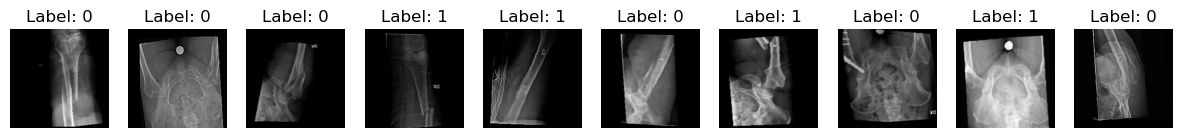

In [13]:


def show_image(dataset, num_images=5):
    # Get some random indices from the dataset
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        # plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()

show_image(train_dataset, 10)


multiple GPU: 2


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch 1/50, train Loss: 0.6990, val Loss: 0.6990, train ACC: 54.01%, Val ACC: 34.62%
Epoch 2/50, train Loss: 0.9349, val Loss: 0.9349, train ACC: 59.85%, Val ACC: 30.77%
Epoch 3/50, train Loss: 1.4342, val Loss: 1.4342, train ACC: 64.96%, Val ACC: 30.77%
Epoch 4/50, train Loss: 0.8989, val Loss: 0.8989, train ACC: 70.80%, Val ACC: 30.77%
Epoch 5/50, train Loss: 0.9049, val Loss: 0.9049, train ACC: 83.21%, Val ACC: 67.31%
Epoch 6/50, train Loss: 1.4252, val Loss: 1.4252, train ACC: 85.40%, Val ACC: 48.08%
Epoch 7/50, train Loss: 1.6005, val Loss: 1.6005, train ACC: 83.94%, Val ACC: 51.92%
Epoch 8/50, train Loss: 3.1784, val Loss: 3.1784, train ACC: 82.48%, Val ACC: 34.62%
Epoch 9/50, train Loss: 2.4290, val Loss: 2.4290, train ACC: 83.94%, Val ACC: 48.08%
Epoch 10/50, train Loss: 1.4106, val Loss: 1.4106, train ACC: 78.10%, Val ACC: 69.23%
Epoch 11/50, train Loss: 1.0671, val Loss: 1.0671, train ACC: 82.48%, Val ACC: 69.23%
Epoch 12/50, train Loss: 0.8906, val Loss: 0.8906, train ACC: 8

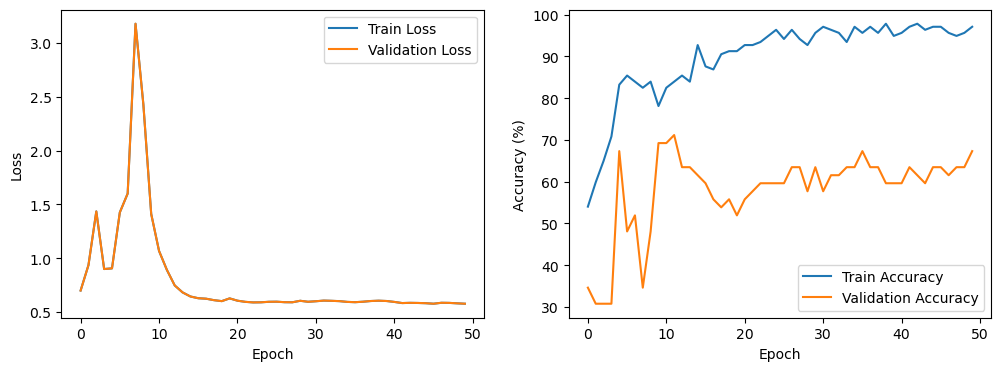

In [14]:
epoch_num = 50
# resnet50
resnet50 = train_model(train_loader, val_loader,
                       classweight=classweight,
                       num_epochs=epoch_num,
                       lr=0.001, step_size=10, gamma=0.1,
                       model_name='resnet50')


Test Loss: 0.5528, Test Acc: 75.00%
AUC: 0.7070707070707071
Confusion Matrix:
[[35 10]
 [ 4  7]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.90      0.78      0.83        45
         AFF       0.41      0.64      0.50        11

    accuracy                           0.75        56
   macro avg       0.65      0.71      0.67        56
weighted avg       0.80      0.75      0.77        56



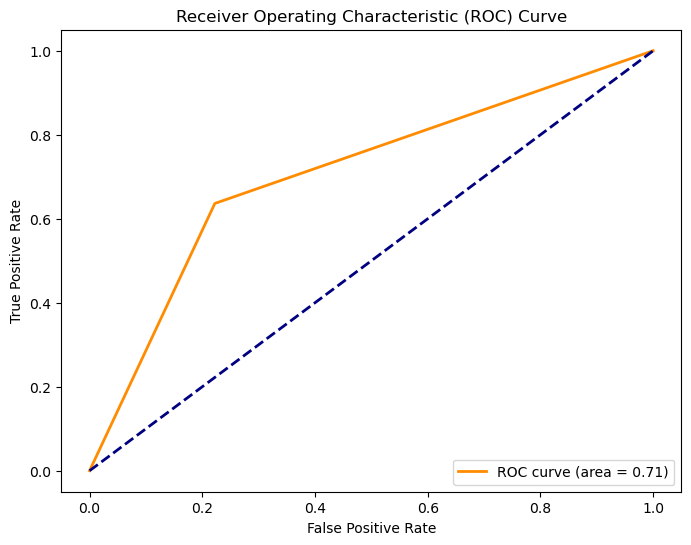

In [15]:
test_model(model=resnet50, test_dataset=test_dataset, batch_size=batch_size)


multiple GPU: 2


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch 1/50, train Loss: 0.7287, val Loss: 0.7287, train ACC: 52.55%, Val ACC: 51.92%
Epoch 2/50, train Loss: 0.7190, val Loss: 0.7190, train ACC: 49.64%, Val ACC: 53.85%
Epoch 3/50, train Loss: 0.6940, val Loss: 0.6940, train ACC: 53.28%, Val ACC: 63.46%
Epoch 4/50, train Loss: 0.6719, val Loss: 0.6719, train ACC: 57.66%, Val ACC: 69.23%
Epoch 5/50, train Loss: 0.6617, val Loss: 0.6617, train ACC: 65.69%, Val ACC: 69.23%
Epoch 6/50, train Loss: 0.6537, val Loss: 0.6537, train ACC: 69.34%, Val ACC: 71.15%
Epoch 7/50, train Loss: 0.6500, val Loss: 0.6500, train ACC: 77.37%, Val ACC: 71.15%
Epoch 8/50, train Loss: 0.6526, val Loss: 0.6526, train ACC: 75.91%, Val ACC: 59.62%
Epoch 9/50, train Loss: 0.6628, val Loss: 0.6628, train ACC: 72.26%, Val ACC: 55.77%
Epoch 10/50, train Loss: 0.6635, val Loss: 0.6635, train ACC: 66.42%, Val ACC: 57.69%
Epoch 11/50, train Loss: 0.6675, val Loss: 0.6675, train ACC: 72.99%, Val ACC: 55.77%
Epoch 12/50, train Loss: 0.6637, val Loss: 0.6637, train ACC: 7

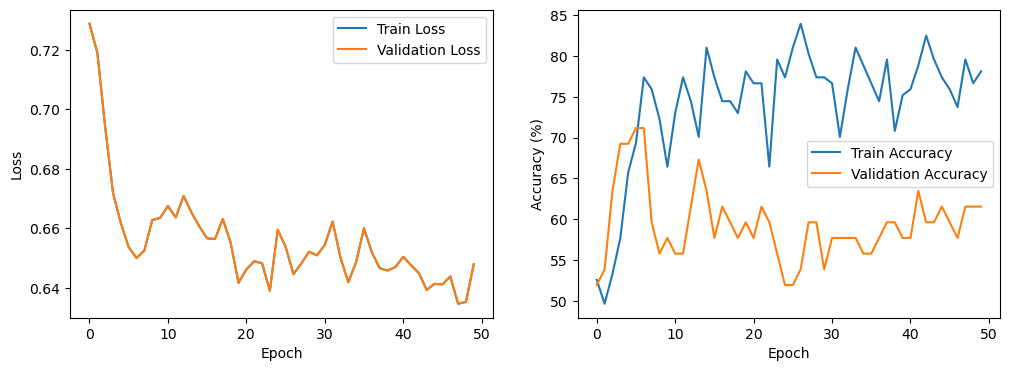

In [16]:
# resnet101
resnet101 = train_model(train_loader, val_loader, classweight, num_epochs=epoch_num, lr=0.0001, step_size=7, gamma=0.1, model_name='resnet101')


Test Loss: 0.6317, Test Acc: 67.86%
AUC: 0.7313131313131314
Confusion Matrix:
[[29 16]
 [ 2  9]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.94      0.64      0.76        45
         AFF       0.36      0.82      0.50        11

    accuracy                           0.68        56
   macro avg       0.65      0.73      0.63        56
weighted avg       0.82      0.68      0.71        56



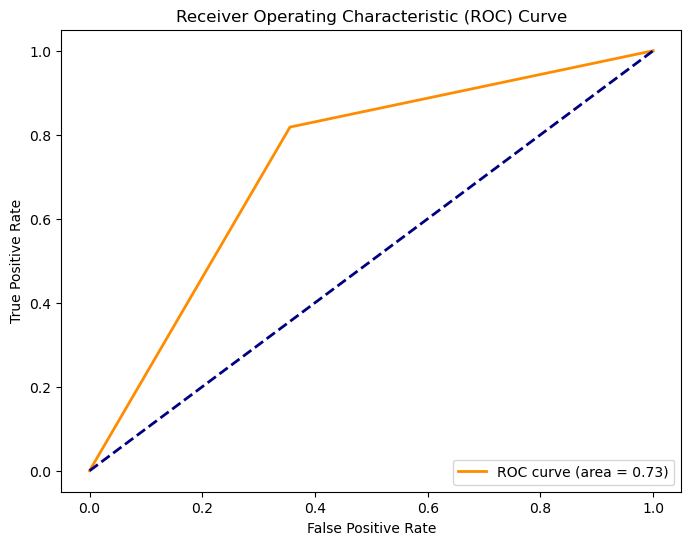

In [17]:
test_model(model=resnet101, test_dataset=test_dataset, batch_size=batch_size)


In [18]:
# resnet152
resnet152 = train_model(train_loader, val_loader, classweight, 
                        num_epochs=epoch_num, lr=0.0001, step_size=7, gamma=0.1, model_name='resnet152')


multiple GPU: 2


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Epoch 1/50, train Loss: 0.7292, val Loss: 0.7292, train ACC: 64.23%, Val ACC: 69.23%
Epoch 2/50, train Loss: 0.7136, val Loss: 0.7136, train ACC: 62.04%, Val ACC: 69.23%
Epoch 3/50, train Loss: 0.7038, val Loss: 0.7038, train ACC: 64.23%, Val ACC: 69.23%
Epoch 4/50, train Loss: 0.6887, val Loss: 0.6887, train ACC: 68.61%, Val ACC: 69.23%
Epoch 5/50, train Loss: 0.6800, val Loss: 0.6800, train ACC: 70.07%, Val ACC: 69.23%
Epoch 6/50, train Loss: 0.6784, val Loss: 0.6784, train ACC: 79.56%, Val ACC: 69.23%
Epoch 7/50, train Loss: 0.6801, val Loss: 0.6801, train ACC: 71.53%, Val ACC: 67.31%
Epoch 8/50, train Loss: 0.6755, val Loss: 0.6755, train ACC: 75.18%, Val ACC: 67.31%


KeyboardInterrupt: 

Test Loss: 0.2229, Test Acc: 90.18%
AUC: 0.8701650151586059
Confusion Matrix:
[[772  61]
 [ 44 192]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.95      0.93      0.94       833
         AFF       0.76      0.81      0.79       236

    accuracy                           0.90      1069
   macro avg       0.85      0.87      0.86      1069
weighted avg       0.90      0.90      0.90      1069



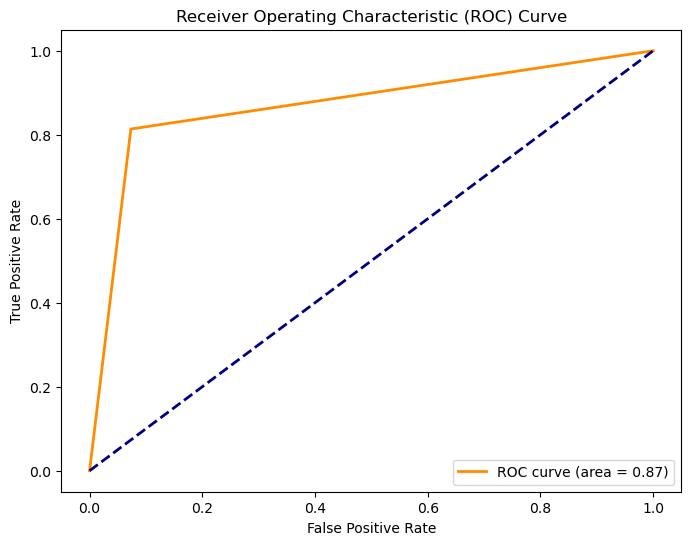

In [259]:
test_model(model=resnet152, test_dataset=test_dataset, batch_size=batch_size)

In [260]:
# densenet161
densenet161 = train_model(train_loader, val_loader, classweight, 
                          num_epochs=epoch_num, lr=0.0001, step_size=5, gamma=0.1, model_name='densenet161')


AttributeError: 'DenseNet' object has no attribute 'conv1'

In [ ]:
test_model(model=densenet161, test_dataset=test_dataset, batch_size=batch_size)